In [1]:
import json, gzip

import numpy as np
import pandas as pd
from ete3 import Tree

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.transforms import offset_copy
import seaborn as sns

from colaml.phyTables import ExtantPhyTable
from colaml.misc import dataplot, modelplot, phyplot, parsimony
from colaml.__main__ import phytbl_from_json, model_from_json

from mydata import filter_table
from myconfig import DATA_DIR, ROOT_DIR, DATASET_DIR, PUBDATA_DIR
from plotutil import *

mm = 1 / 25.4

In [2]:
%matplotlib inline

In [3]:
data_path = DATA_DIR/'inspect-real-data'/'bacteria'/'bacteria-lmax2-filt05.json.gz'
phytbl, columns = phytbl_from_json(data_path, 2)
tree = phytbl.tree.to_ete3()

In [4]:
model_path = ROOT_DIR/'results'/'bacteria-lmax2-filt05.bestfit.json.gz'
mmm = model_from_json(model_path)

In [5]:
with gzip.open(ROOT_DIR/'results'/'bacteria-lmax2-filt05-mrglrecon.json.gz') as file:
    tmp = json.load(file)
    
tree = Tree(tmp['tree'], format=3)
reconcpy = pd.DataFrame(**tmp['recon'])
reconcat = pd.DataFrame(**tmp['otherstates'][0]['states'])

In [6]:
cogannot = pd.read_excel(
    PUBDATA_DIR/'cog'/'Protein_family_annotations.xlsx', sheet_name='v4_root_pps_only', 
    usecols=['FAM', 'Category', 'Process', 'Category_description', 'COG_description'], index_col='FAM'
)

In [7]:
cogJ = cogannot[cogannot['Category'].eq('J')]
cogE = cogannot[cogannot['Category'].eq('E')]

In [8]:
cogannot.loc[{*reconcat.columns} & ({*cogJ.index} & {*cogE.index})]

/tmp/ipykernel_3241611/578154801.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cogannot.loc[{*reconcat.columns} & ({*cogJ.index} & {*cogE.index})]


,Category,Process,Category_description,COG_description
FAM,,,,
COG0252,J,Information_storage_and_processing,Translation_ribosomal_structure_and_biogenesis,asparaginase activity
COG0252,E,Metabolism,Amino_acid_transport_and_metabolism,asparaginase activity


In [9]:
spp = pd.read_csv(DATA_DIR/'pubdata'/'Coleman-et-al-21'/'SpeciesTable.tsv', sep='\t', index_col=0)
tax = spp.loc[
    tree.get_leaf_names(), 'GTDB Taxonomy'
].str.split(';', expand=True).rename(columns='dpcofgs'.__getitem__)

In [10]:
phylum_annot = dict(
    p__Deinococcota        = 'DST'              , 
    p__Thermotogota        = 'DST'              , 
    p__Synergistota        = 'DST'              , 
    p__Margulisbacteria    = 'Margulisbacteria' , 
    p__Cyanobacteria       = 'Cyanobacteria'    , 
    p__Eremiobacterota     = 'Eremiobacterota'  , 
    p__Armatimonadota      = 'Armatimonadota'   , 
    p__Dormibacterota      = 'Dormibacterota'   , 
    p__Chloroflexota_A     = 'Chloroflexota'    , 
    p__Chloroflexota       = 'Chloroflexota'    , 
    p__Patescibacteria     = 'CPR'              , 
    p__Actinobacteriota    = 'Actinobacteriota' , 
    p__Firmicutes          = 'Firmicutes'       ,
    p__Firmicutes_A        = 'Firmicutes'       , 
    p__Firmicutes_B        = 'Firmicutes'       , 
    p__Firmicutes_C        = 'Firmicutes'       , 
    p__Firmicutes_D        = 'Firmicutes'       , 
    p__Firmicutes_E        = 'Firmicutes'       , 
    p__Firmicutes_F        = 'Firmicutes'       , 
    p__Firmicutes_G        = 'Firmicutes'       , 
    p__Firmicutes_I        = 'Firmicutes'       , 
    p__Firmicutes_K        = 'Firmicutes'       , 
    p__Fusobacteriota      = 'Fusobacteriota'   , 
    p__Spirochaetota       = 'Spirochaetota'    , 
    p__Elusimicrobiota     = 'Elusimicrobiota'  , 
    p__Omnitrophota        = 'PVC'              , 
    p__Verrucomicrobiota_A = 'PVC'              , 
    p__Verrucomicrobiota   = 'PVC'              , 
    p__Planctomycetota     = 'PVC'              , 
    p__Cloacimonadota      = 'FCB'              , 
    p__Gemmatimonadota     = 'FCB'              , 
    p__Fibrobacterota      = 'FCB'              , 
    p__Marinisomatota      = 'FCB'              , 
    p__Bacteroidota        = 'FCB'              , 
    p__Dependentiae        = 'Dependentiae'     , 
    p__Deferribacterota    = 'ACD'              , 
    p__Aquificota          = 'ACD'              , 
    p__Campylobacterota    = 'ACD'              , 
    p__Acidobacteriota     = 'Acidobacteriota'  , 
    p__Nitrospirota        = 'Nitrospirota'     , 
    p__Proteobacteria      = 'Proteobacteria'   , 
    p__Bdellovibrionota    = 'Bdellovibrionota' , 
    p__Myxococcota         = 'Myxococcota'      , 
    p__Desulfuromonadota   = 'Desulfuromonadota', 
    p__Desulfobacterota    = 'Desulfobacterota' , 
    p__Desulfobacterota_A  = 'Desulfobacterota' , 
)

In [11]:
phylum_counts = (
    tax
    .assign(annot = lambda df: df['p'].map(phylum_annot))
    .assign(group = lambda df: df['annot'].ne(df['annot'].shift(1)).cumsum())
    .groupby(['group','annot'])
    .size()
)

phylum_loc = pd.concat(
    [phylum_counts, phylum_counts.cumsum() - phylum_counts], 
    axis=1, keys=['cnt', 'cum']
)

In [12]:
def show_history(idx, ncat, N=32, which='category', ax=None):
    from matplotlib.colors import LinearSegmentedColormap, to_rgba
    
    if which != 'category':
        raise NotImplementedError
    
    if ax is None:
        ax = plt.gca()
        
    cmaps = {
        ((x, a), (y, b)): LinearSegmentedColormap.from_list(
            f'({x},{a})->({y},{b})', 
            # [to_rgba(f'C{x}', alpha=0.2 + 0.8 * a), to_rgba(f'C{y}', alpha=0.2 + 0.8 * b)], N=N
            [to_rgba(f'C{x}', alpha=1), to_rgba(f'C{y}', alpha=1)], N=N
        )
        for x in range(ncat) for a in range(2)
        for y in range(ncat) for b in range(2)
        if (x, a) != (y, b)
    }
    #lws = {
    #    (True , False): np.linspace(0.50, 0.25, N), 
    #    (True , True ): np.full(N, 0.50), 
    #    (False, True ): np.linspace(0.25, 0.50, N), 
    #    (False, False): np.full(N, 0.25), 
    #}
    
    tmp_tree = tree.copy()
    
    nodelc = {}
    nodelw = {}
    for nd in [*tmp_tree.traverse()]:
        if nd.is_root():
            continue

        mycopy, upcopy = reconcpy[idx][[nd.name, nd.up.name]].ne(0)
        mycat , upcat  = reconcat[idx][[nd.name, nd.up.name]]
        #nodelc[nd] = to_rgba(f'C{mycat}', alpha=0.2 + 0.8 * mycopy) # cmaps[(upcat, upcopy), (mycat, mycopy)](N-1)
        nodelc[nd] = to_rgba(f'C{mycat}', alpha=1)
        nodelw[nd] = 0.5 if mycopy else 0.2

        if (mycat, mycopy) == (upcat, upcopy):
            continue

        e = nd
        e.dist /= N
        nodelc[e] = cmaps[(upcat, upcopy), (mycat, mycopy)](0)
        for i in range(1, N):
            e = e.add_child()
            for s in e.get_sisters():
                e.add_child(s.detach())
            e.dist, e.name = e.up.dist, e.up.name
            e.up.name = None
            nodelc[e] = cmaps[(upcat, upcopy), (mycat, mycopy)](i)
            nodelw[e] = nodelw[nd] #lws[upcopy, mycopy][i]

    _, h = tmp_tree.get_farthest_leaf()

    phyplot.draw(
        tmp_tree, horizontal=True, show_confidence=False, 
        nodelw=nodelw, nodelc=nodelc, node_text=None, ax=ax, 
    )
    ax.imshow(
        reconcpy.loc[tmp_tree.get_leaf_names(), [idx]], 
        aspect='auto', interpolation='none', cmap='bone_r', 
        origin='upper', extent=(h * 1.04, h * 1.11, len(tmp_tree)-0.5, -0.5)
    )
    ax.autoscale()
    ax.set_ybound(lower=-0.5, upper=len(tmp_tree)-0.5)
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    return ax

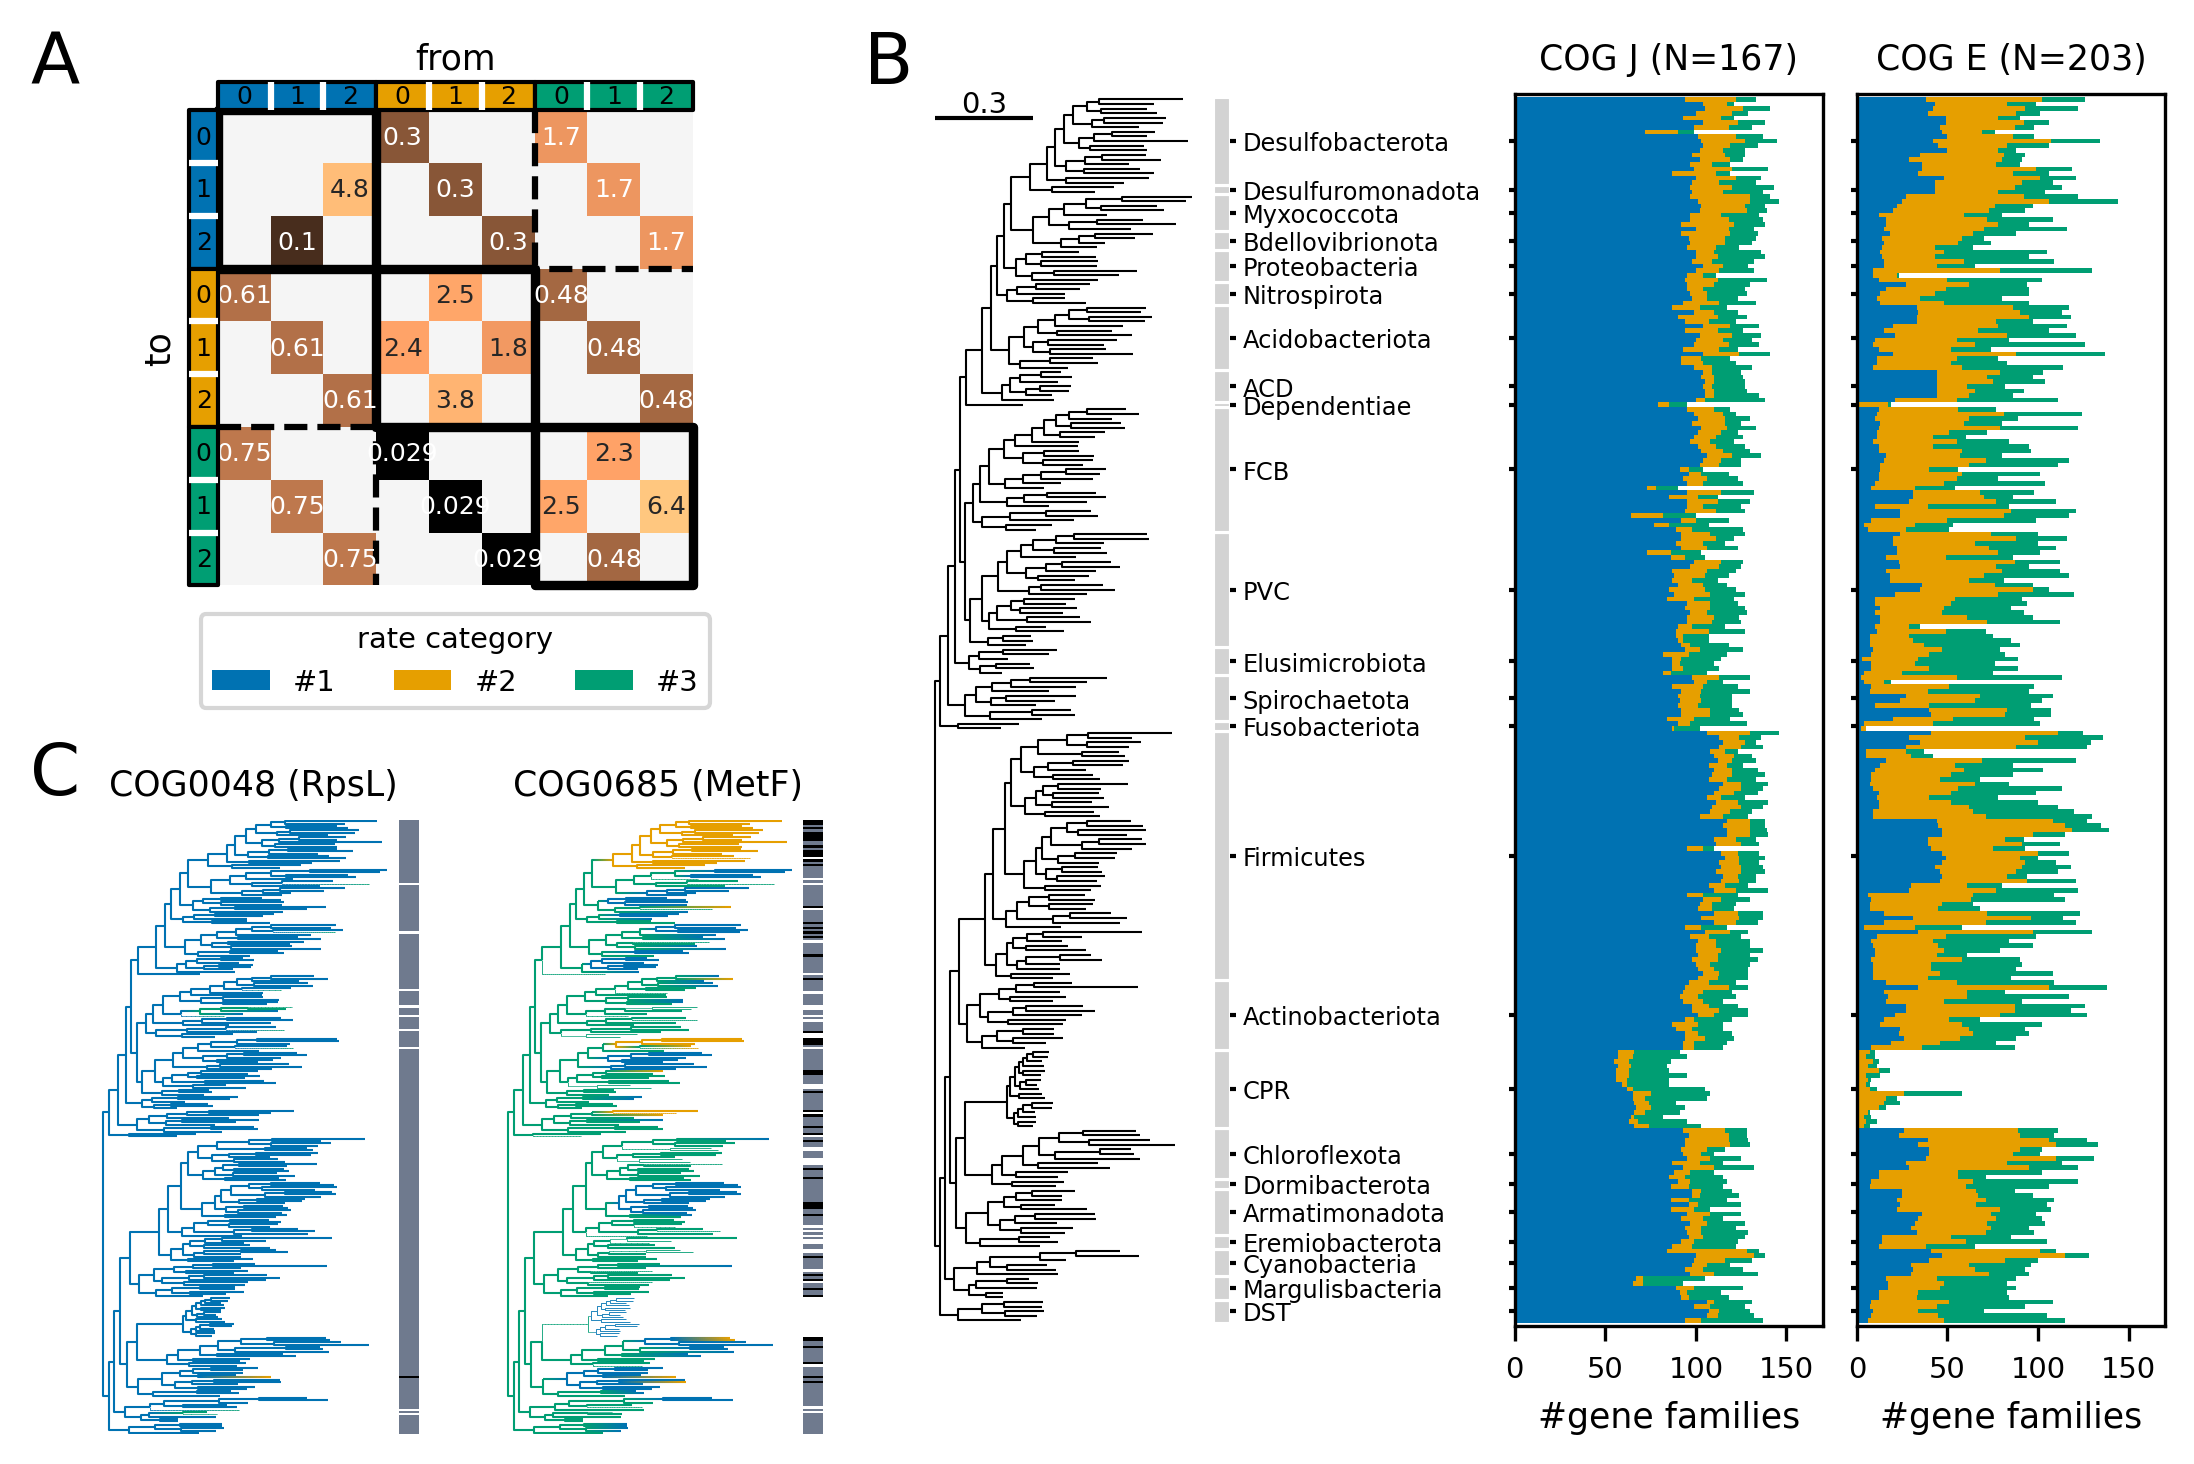

In [13]:
with plt.rc_context({'axes.prop_cycle': OkabeItoCUDcy}):
    fig = plt.figure(layout='constrained', figsize=(178*mm, 120*mm), dpi=300)

    subfigAC, panelB = fig.subfigures(1, 2, width_ratios=[3, 5], wspace=0.07)
    panelA, panelC = subfigAC.subfigures(2, 1, height_ratios=[8, 8], hspace=0.05)

    ax = panelA.subplots()
    ax.set_aspect('equal')

    with plt.rc_context({'font.size': 6}):
        modelplot.plot_substmodel(mmm.substmodel, ax=ax)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    ax.set_xlabel('from', labelpad=10, fontsize='small', visible=True)
    ax.set_ylabel('to'  , labelpad=10, fontsize='small', visible=True)
    
    ax.legend(
        [plt.Rectangle((0,0),0,0,fc=fc) for fc in ('C0','C1','C2')], 
        ['#1','#2','#3'], 
        loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.03), fontsize='x-small', 
        title='rate category', title_fontsize='x-small'
    )
    
    axB0, axB2, axB3 = panelB.subplot_mosaic('123', sharey=True, gridspec_kw=dict(wspace=0)).values()

    axB2.sharey(axB0)
    axB3.sharey(axB0)
    axB3.sharex(axB2)
    for cat, ax in zip('JE', [axB2, axB3]):
        cogidx = cogannot[cogannot['Category'].eq(cat)].index
        catdf = reconcat.loc[
            tree.get_leaf_names(), 
            reconcat.columns.intersection(cogidx)
        ]
        cpydf = reconcpy.loc[
            tree.get_leaf_names(), 
            reconcpy.columns.intersection(cogidx)
        ]
        catcnt = catdf.astype(pd.Int8Dtype()).mask(cpydf.eq(0)).apply(lambda s: s.value_counts(), axis=1)
        catcnt.plot.barh(stacked=True, width=1, ax=ax, legend=False)
        ax.yaxis.set_tick_params(which='major', size=1.5, width=1)
        ax.yaxis.set_tick_params(which='minor', left=False)
        ax.xaxis.set_tick_params(labelsize='x-small')
        ax.xaxis.set_major_locator(plt.MultipleLocator(50))
        ax.set_xlabel('#gene families', size='small')
        ax.set_xlim(0, 170)
        ax.set_title(f'COG {cat} (N={len(catdf.columns)})', size='small')

    ## tree
    phyplot.draw(tree, show_confidence=False, node_text=None, ax=axB0, nodelw=0.5, horizontal=True)
    
    ## scale bar
    axB0.hlines(260, 0.0, 0.3, color='k', lw=1)
    axB0.text(0.15, 260, '0.3', ha='center', va='bottom', fontsize='x-small')
    
    axB0.set_frame_on(False)
    axB0.xaxis.set_tick_params(bottom=False, labelbottom=False)
    axB0.yaxis.set_tick_params(which='both', left=False, labelleft=False)

    ## phylum annotation
    segments = []
    yticks = []
    for (_, phy), cnt, cum in phylum_loc.itertuples():
        segments.append(plt.Rectangle((0.85, cum-0.5), 0.05, cnt))
        yticks.append((cum + cnt / 2 - 0.5, phy))
    axB0.add_collection(PatchCollection(segments, fc='lightgray', ec='w', lw=0.75))
    axB0.set_xbound(upper=0.9)
    axB0.set_yticks(*zip(*yticks), size='xx-small')
    axB0.tick_params(
        axis='y', which='major', size=1.5, width=1, pad=1.5, 
        right=True, labelright=True
    )
    axB0.invert_yaxis()
    
    axC0, axC1 = panelC.subplots(1, 2, gridspec_kw=dict(wspace=0.07), sharey=True)
    show_history('COG0048', 3, ax=axC0)
    axC0.set_title('COG0048 (RpsL)', fontsize='small')
    show_history('COG0685', 3, ax=axC1)
    axC1.set_title('COG0685 (MetF)', fontsize='small')

    panelA.text(
        0, 1, 'A', ha='left', va='top', fontsize='xx-large', 
        transform=offset_copy(panelA.transSubfigure, fig=fig, x=-0.15, y=0.00)
    )
    panelB.text(
        0, 1, 'B', ha='left', va='top', fontsize='xx-large', 
        transform=offset_copy(panelB.transSubfigure, fig=fig, x=-0.15, y=0.00)
    )
    panelC.text(
        0, 1, 'C', ha='left', va='top', fontsize='xx-large', 
        transform=offset_copy(panelC.transSubfigure, fig=fig, x=-0.15, y=0.05)
    )
    fig.canvas.draw()
    
    fig.savefig('jpg/usecase-bact.jpg', bbox_inches='tight', dpi=350)
    fig.savefig('png/usecase-bact.png', bbox_inches='tight', dpi=350)
    fig.savefig('pdf/usecase-bact.pdf', bbox_inches='tight')